Naive Markowitz

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import root_scalar

# Load data (fixed separator warning)
df = pd.read_csv("data.csv", sep=";", index_col=0, parse_dates=True, dayfirst=False)
returns = df.pct_change().dropna()
returns = returns[(returns.index >= "2021-10-01") & (returns.index < "2024-01-01")]
prices = df.loc[returns.index]

# Parameters
window = 90
vol_target_annual = 0.2495
risk_free_rate_annual = 0.05
risk_free_rate_daily = risk_free_rate_annual / 365
transaction_fee = 0.001
initial_portfolio_value = 1_000_000
rebalance_freq = 30
n_assets = returns.shape[1]

def run_strategy_for_gamma(gamma):
    weights_history = []
    weights_rf_history = []
    portfolio_returns = []
    portfolio_value = initial_portfolio_value
    portfolio_values = [initial_portfolio_value]
    total_fees = 0.0

    prices_today = prices.iloc[window]
    current_w = np.ones(n_assets) / n_assets
    asset_values = current_w * portfolio_value
    delta = asset_values / prices_today.values
    delta_0 = 0.0

    for t in range(window, len(returns) - 1):
        rebalance_today = (t - window) % rebalance_freq == 0
        window_returns = returns.iloc[t - window:t]

        # Fix: skip invalid windows
        if window_returns.shape[1] == 0 or window_returns.isnull().values.any():
            continue

        prices_today = prices.iloc[t]
        prices_next = prices.iloc[t + 1]

        # Calculation of the new portfolio value
        risky_value = np.sum(delta * prices_today.values)
        rf_value = delta_0 * (1 + risk_free_rate_daily)
        portfolio_value = risky_value + rf_value

        # Update the weights
        pre_rebalance_w = (delta * prices_today.values) / portfolio_value if portfolio_value > 1e-12 else np.zeros(n_assets)
        pre_rebalance_w_rf = rf_value / portfolio_value if portfolio_value > 1e-12 else 0.0

        if rebalance_today:
            mu = window_returns.mean().values
            Sigma = window_returns.cov().values

            w = cp.Variable(n_assets)
            w_rf = cp.Variable(1)

            risk_term = 0.5 * cp.quad_form(w, Sigma)
            expected_return = mu.T @ w + risk_free_rate_daily * w_rf
            objective = cp.Minimize(risk_term - gamma * expected_return)

            constraints = [
                w >= 0,
                w_rf >= 0,
                cp.sum(w) + w_rf == 1
            ]

            prob = cp.Problem(objective, constraints)
            try:
                prob.solve(solver=cp.SCS, verbose=False)
                new_w = w.value
                new_w_rf = w_rf.value[0]
            except:
                new_w = pre_rebalance_w
                new_w_rf = pre_rebalance_w_rf
        else:
            new_w = pre_rebalance_w
            new_w_rf = pre_rebalance_w_rf

        # Calculation of the fees
        if rebalance_today:
            target_risky_values = new_w * portfolio_value
            current_risky_values = delta * prices_today.values
            delta_s = target_risky_values - current_risky_values
            fees = np.sum(np.abs(delta_s)) * transaction_fee
            total_fees += fees

            # Update the number of units held
            delta = target_risky_values / prices_today.values
            delta_0 = (new_w_rf * portfolio_value - fees) / (1 + risk_free_rate_daily)
        else:
            delta_0 *= (1 + risk_free_rate_daily)

        # Calculation of the new portfolio value
        risky_value_next = delta * prices_next.values
        rf_value_next = delta_0 * (1 + risk_free_rate_daily)
        prev_portfolio_value = portfolio_value
        portfolio_value = np.sum(risky_value_next) + rf_value_next
        portfolio_values.append(portfolio_value)
        net_return = (portfolio_value - prev_portfolio_value) / prev_portfolio_value

        # Storage
        weights_history.append(risky_value_next / portfolio_value)
        weights_rf_history.append(rf_value_next / portfolio_value)
        portfolio_returns.append(net_return)

    return np.array(portfolio_returns), portfolio_value, np.array(weights_history), np.array(portfolio_values), total_fees, np.array(weights_rf_history)

# Goal function to find the optimal gamma
def objective_gamma(gamma):
    rets = run_strategy_for_gamma(gamma)[0]
    vol_annual = np.std(rets) * np.sqrt(365)
    return vol_annual - vol_target_annual

gamma_init = 1.0
result = root_scalar(objective_gamma, method='brentq', bracket=[1e-4, 1e4], xtol=1e-4)
gamma_opt = result.root

# Calculation of the performance metrics
final_returns, portfolio_value, weights_hist, portfolio_values, total_fees, weights_rf_history = run_strategy_for_gamma(gamma_opt)
T = len(final_returns)
annual_ret = (365 / T) * (portfolio_value - initial_portfolio_value) / initial_portfolio_value
annual_cumulative = (1 + final_returns).cumprod() - 1
annual_vol = np.std(final_returns, ddof=1) * np.sqrt(365)
r_bar = np.mean(final_returns) * 365
sharpe = ((r_bar - risk_free_rate_annual) / annual_vol)

# Calculation of the diversification
diversification_scores = []
for w in weights_hist:
    H_x = np.sum(w**2) / (np.sum(w))**2
    D_x = 1 / (len(w) * H_x)
    diversification_scores.append(D_x)
avg_diversification = np.mean(diversification_scores)

# Calculation of the maximum drawdown
cum_max = np.maximum.accumulate(portfolio_values)
drawdowns = (cum_max - portfolio_values) / cum_max
max_drawdown = np.max(drawdowns)

# Calculation of the fee cost
fee_cost = total_fees / initial_portfolio_value
avg_risk_free_allocation = np.mean(weights_rf_history) * 100

Bitcoin only

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load the dataset (dates already in index)
df = pd.read_csv("data.csv", sep=";", index_col=0, parse_dates=True)

# Select only the backtest period
df = df.loc["2022-01-01":"2024-01-01"]

# Calculation of daily returns only for Bitcoin
bitcoin_prices = df.iloc[:, 0]  # <-- première colonne (souvent 'bitcoin')
initial_btc_price = bitcoin_prices.iloc[0]
daily_returns = bitcoin_prices.pct_change().dropna()

# Initial investment
initial_portfolio_value = 1_000_000

# Calculation of the evolution of the portfolio value
btc_quantity = initial_portfolio_value / initial_btc_price
portfolio_values_bitcoin = bitcoin_prices * btc_quantity

# Calculation of maximum drawdown
cummax = portfolio_values_bitcoin.cummax()
drawdown = (cummax - portfolio_values_bitcoin) / cummax
max_drawdown = drawdown.max()

# Calculation of mean daily return
mean_daily_return = daily_returns.mean()

T = len(daily_returns)


Boosted Markowitz

In [7]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- Constants ---
risk_free_annual = 0.05
trading_days = 365
risk_free_daily = (1 + risk_free_annual) ** (1 / trading_days) - 1
EPS = 1e-12

# --- Diversity function ---
def diversity_full(weights):
    """Compute diversity only on risky assets (exclude cash)."""
    w = np.array(weights[:-1], dtype=float)
    n = len(w)
    denom = np.sum(w**2)
    return (np.sum(w)**2) / (n * denom) if denom > EPS else 0.0

# --- Objective function ---
def neg_sharpe_full(weights, mean_ret, cov, lambda_vol, lambda_div, fee_penalty, prev_weights):
    """Penalized negative Sharpe ratio objective."""
    w = np.asarray(weights[:-1], dtype=float)
    w_rf = float(weights[-1])

    port_return_daily = np.dot(w, mean_ret) + w_rf * risk_free_daily
    var_daily = float(np.dot(w, cov @ w))
    port_vol_daily = np.sqrt(max(var_daily, 0.0))

    port_return_annual = port_return_daily * trading_days
    port_vol_annual = port_vol_daily * np.sqrt(trading_days)

    div = diversity_full(weights)

    penalty = 0.0
    if port_vol_annual > 0.25:
        penalty += lambda_vol * (port_vol_annual - 0.25) ** 2
    if div < 0.7:
        penalty += lambda_div * (0.7 - div) ** 2

    turnover = np.sum(np.abs(weights - prev_weights))
    penalty += fee_penalty * turnover

    denom = max(port_vol_annual, EPS)
    sharpe = (port_return_annual - risk_free_annual) / denom
    return -sharpe + penalty

# --- Backtest (no internal plots) ---
def run_backtest_fixed(file_path, window, rebalance_period,
                       lambda_vol, lambda_div, fee_penalty=3.0,
                       start_date=None, end_date=None):
    """Run boosted Markowitz backtest (vol/div/turnover penalization)."""
    transaction_fee_rate = 0.001
    initial_value = 1_000_000.0

    # Load & clean data
    df = pd.read_csv(file_path, sep=";", engine="python")
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.set_index("date")
    df = df.sort_index()
    df = df.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    returns = df.pct_change().dropna()
    n_assets = returns.shape[1]

    # Date range
    if start_date is None:
        start_date = returns.index.min() + pd.Timedelta(days=window)
    else:
        start_date = pd.to_datetime(start_date)
    if end_date is None:
        end_date = returns.index.max()
    else:
        end_date = pd.to_datetime(end_date)
    returns = returns.loc[start_date - pd.Timedelta(days=window): end_date]

    # Rebalance schedule
    dates_rebalance = [start_date]
    while dates_rebalance[-1] + pd.Timedelta(days=rebalance_period) <= end_date:
        next_date = dates_rebalance[-1] + pd.Timedelta(days=rebalance_period)
        valid_dates = returns.index[returns.index >= next_date]
        if len(valid_dates) == 0:
            break
        dates_rebalance.append(valid_dates[0])

    # Initialization
    current_value = initial_value
    total_fees = 0.0
    portfolio_values = [current_value]
    portfolio_dates = [start_date]
    weights_record = []
    current_weights = np.zeros(n_assets + 1)
    current_weights[-1] = 1.0
    position_values = current_weights * current_value

    # === Backtest loop ===
    for date in returns.index[returns.index >= start_date]:
        daily_ret = returns.loc[date].fillna(0.0).values
        ret_full = np.append(daily_ret, risk_free_daily)

        position_values *= (1.0 + ret_full)
        current_value = float(np.sum(position_values))
        current_weights = position_values / current_value

        if date in dates_rebalance:
            pre_rebal_weights = current_weights.copy()
            data_window = returns.loc[date - pd.Timedelta(days=window):date - pd.Timedelta(days=1)]

            mean_ret = data_window.mean().values
            cov = data_window.cov().values

            x0 = pre_rebal_weights.copy()
            if x0.sum() <= EPS:
                x0 = np.ones(n_assets + 1) / (n_assets + 1)
            x0 /= np.sum(x0)

            bounds = [(0, 1)] * (n_assets + 1)
            cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

            res = minimize(
                neg_sharpe_full, x0,
                args=(mean_ret, cov, lambda_vol, lambda_div, fee_penalty, pre_rebal_weights),
                bounds=bounds, constraints=cons,
                method="SLSQP", options={"maxiter": 500, "ftol": 1e-9}
            )
            target_weights = res.x

            # Fees
            turnover = np.sum(np.abs(target_weights - pre_rebal_weights))
            fee = turnover * transaction_fee_rate * current_value
            cash_value = position_values[-1]
            if fee > cash_value:
                scale = cash_value / fee
                target_weights = pre_rebal_weights + scale * (target_weights - pre_rebal_weights)
                fee = cash_value

            position_values[-1] -= fee
            total_fees += fee
            current_value = np.sum(position_values)

            # Update positions
            position_values = target_weights * current_value
            current_weights = position_values / current_value

        portfolio_values.append(current_value)
        portfolio_dates.append(date)
        weights_record.append(current_weights.copy())

    # === Stats ===
    values = np.array(portfolio_values)
    daily_returns = values[1:] / values[:-1] - 1
    ann_return = (values[-1]/values[0])**(trading_days/len(values)) - 1
    ann_vol = np.std(daily_returns, ddof=1) * np.sqrt(trading_days)
    sharpe = (np.mean(daily_returns)*trading_days - risk_free_annual) / max(ann_vol, EPS)
    mean_weights = np.mean(weights_record, axis=0)
    div = diversity_full(mean_weights)

    # === Return results ===
    return {
        'return': ann_return,
        'vol': ann_vol,
        'sharpe': sharpe,
        'diversity': div,
        'weights': mean_weights,
        'values': values,
        'fees_total': total_fees,
        'weights_record': weights_record,
        'dates': portfolio_dates,
        'rebalance_dates': dates_rebalance
    }

# === Example run ===
file_path = "data.csv"
window = 100
rebalance_period = 7
lambda_vol = 10000
lambda_div = 5000
start_date = "2022-01-01"
end_date = "2024-01-01"

result_boosted = run_backtest_fixed(
    file_path=file_path,
    window=window,
    rebalance_period=rebalance_period,
    lambda_vol=lambda_vol,
    lambda_div=lambda_div,
    start_date=start_date,
    end_date=end_date,
    fee_penalty=1.1
)


Reference

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load the dataset (dates already in index)
df = pd.read_csv("data.csv", sep=";", index_col=0, parse_dates=True)

# Select only the backtest period
df = df.loc["2022-01-01":"2024-01-01"]

# Initial investment
initial_portfolio_value = 1_000_000
daily_interest_rate = 0.05 / 365  # Daily equivalent of 5% annual rate

# Create a Series with the same index, filled by compounding the daily rate
portfolio_values_free_risk = pd.Series(index=df.index, dtype=float)
portfolio_values_free_risk.iloc[0] = initial_portfolio_value
for i in range(1, len(portfolio_values_free_risk)):
    portfolio_values_free_risk.iloc[i] = portfolio_values_free_risk.iloc[i-1] * (1 + daily_interest_rate)

# Constant daily returns (cash)
daily_returns = pd.Series(daily_interest_rate, index=df.index[1:])

# Max drawdown (should be 0 for risk-free compounding)
cummax = portfolio_values_free_risk.cummax()
drawdown = (cummax - portfolio_values_free_risk) / cummax
max_drawdown = drawdown.max()

# Mean daily return
mean_daily_return = daily_returns.mean()

T = len(daily_returns)

# Performance metrics
# Annualized return over the observed horizon:
# - exact annualization: (final/initial)^(365/T) - 1
annualized_return = (portfolio_values_free_risk.iloc[-1] / initial_portfolio_value) ** (365 / T) - 1


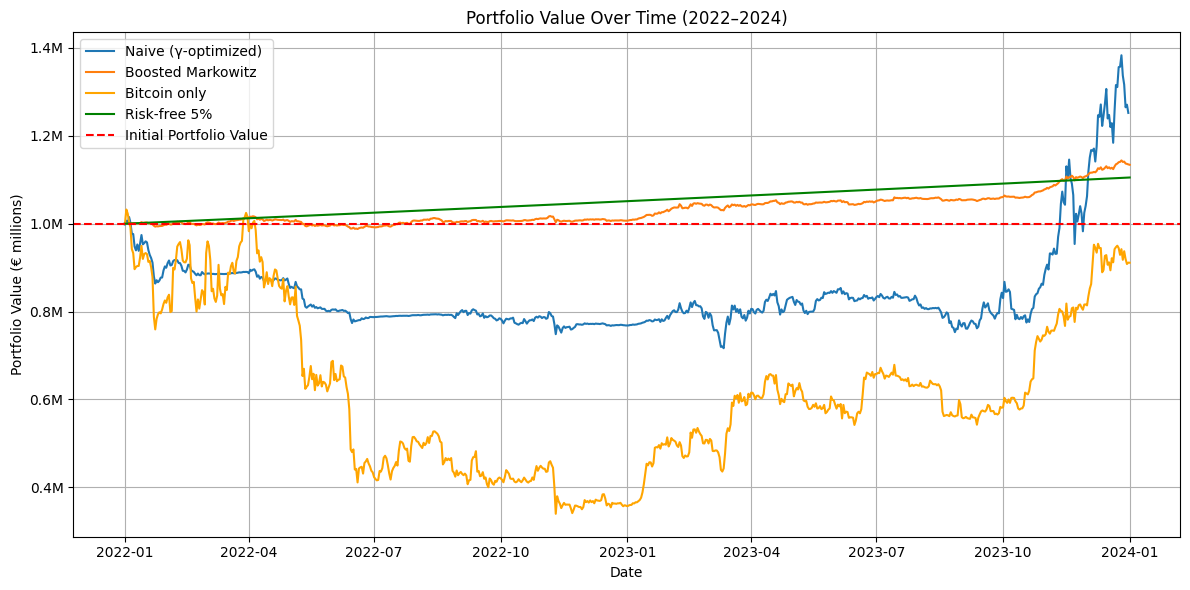

In [10]:
plt.figure(figsize=(12, 6))

# === Courbe 1 : Naive portfolio (γ-optimized) ===
plt.plot(
    returns[(returns.index >= "2021-12-31") & (returns.index < "2024-01-01")].index,
    portfolio_values[1:],                      # <-- ton portefeuille naïf optimisé
    label="Naive (γ-optimized)"
)

# === Courbe 2 : Boosted Markowitz ===
plt.plot(
    result_boosted["dates"],
    result_boosted["values"],
    label="Boosted Markowitz"
)

# === Courbe 3 : Bitcoin seul ===
plt.plot(
    portfolio_values_bitcoin,
    label="Bitcoin only",
    color="orange"
)

# === Courbe 4 : Portefeuille sans risque (cash à 5%) ===
plt.plot(
    portfolio_values_free_risk,
    label="Risk-free 5%",
    color="green"
)

# === Mise en forme du graphique ===
plt.title("Portfolio Value Over Time (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (€ millions)")

# Mise en forme propre des échelles
plt.ticklabel_format(axis='y', style='plain', useMathText=True)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

# Ligne horizontale = valeur initiale
plt.axhline(
    y=initial_portfolio_value,
    color='red',
    linestyle='--',
    label='Initial Portfolio Value'
)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


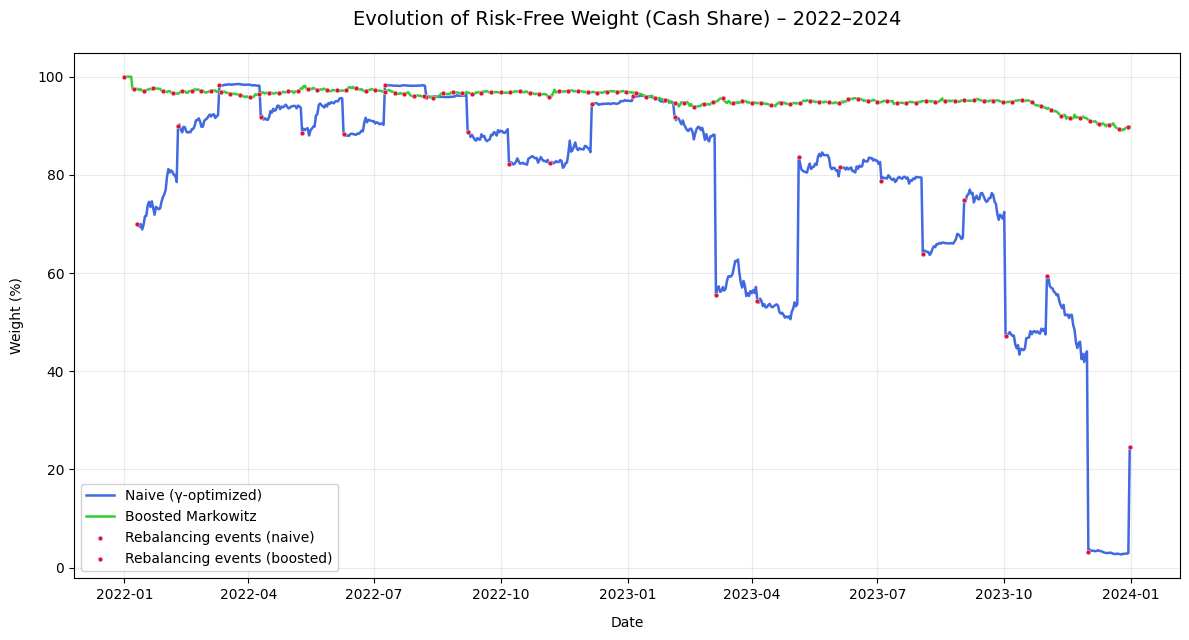

In [13]:
# === 0) Préparation des données ===

# Index temporel & poids du portefeuille naïf
dates_weights = returns.index[window + 1 : len(returns)]
rf_weights = np.asarray(weights_rf_history, dtype=float)  # historique du cash (naïf)

# Aligner longueurs Naïf
min_len_naive = min(len(dates_weights), len(rf_weights))
dates_weights_aligned = dates_weights[:min_len_naive]
rf_weights_aligned = rf_weights[:min_len_naive]

# Dates de rebalancement naïf (tous les rebalance_freq points)
rebalance_indices_naive = [i for i in range(min_len_naive) if (i % rebalance_freq) == 0]
rebalance_dates_naive = [dates_weights_aligned[i] for i in rebalance_indices_naive]
rebalance_values_naive = [rf_weights_aligned[i] for i in rebalance_indices_naive]

# Données du Boosted Markowitz
weights_record_boosted = result_boosted["weights_record"]
dates_boosted = pd.to_datetime(result_boosted["dates"])
rebalance_dates_boosted = result_boosted["rebalance_dates"]

cash_weights_boosted = np.array([w[-1] for w in weights_record_boosted], dtype=float)

# Aligner longueurs Boosted
min_len_boosted = min(len(dates_boosted), len(cash_weights_boosted))
dates_boosted_aligned = dates_boosted[:min_len_boosted]
cash_weights_boosted_aligned = cash_weights_boosted[:min_len_boosted]

# Indices de rebalancement Boosted (assure-toi qu'ils tombent dans la fenêtre alignée)
rebalance_idx_boosted_all = [dates_boosted_aligned.tolist().index(d)
                             for d in rebalance_dates_boosted
                             if d in dates_boosted_aligned.tolist()]
rebalance_dates_boosted_plot = [dates_boosted_aligned[i] for i in rebalance_idx_boosted_all]
rebalance_values_boosted = [cash_weights_boosted_aligned[i] for i in rebalance_idx_boosted_all]

# === 1) Tracé de l’évolution des poids risk-free ===
plt.figure(figsize=(12, 6.5))

# --- Courbe Naive (γ-optimized) ---
plt.plot(
    dates_weights_aligned,
    rf_weights_aligned * 100.0,   # en %
    label="Naive (γ-optimized)",
    color="royalblue",
    linewidth=1.8
)

# --- Courbe Boosted Markowitz ---
plt.plot(
    dates_boosted_aligned,
    cash_weights_boosted_aligned * 100.0,   # en %
    label="Boosted Markowitz",
    color="limegreen",
    linewidth=1.8
)

# --- Événements de rebalancement (rouge) ---
plt.scatter(
    rebalance_dates_naive,
    np.array(rebalance_values_naive) * 100.0,
    color="crimson",
    label="Rebalancing events (naive)",
    zorder=5,
    s=12,
    edgecolor="white",
    linewidth=0.3
)

plt.scatter(
    rebalance_dates_boosted_plot,
    np.array(rebalance_values_boosted) * 100.0,
    color="crimson",
    label="Rebalancing events (boosted)",
    zorder=5,
    s=12,
    edgecolor="white",
    linewidth=0.3
)

# === 2) Mise en forme du graphique ===
plt.title("Evolution of Risk-Free Weight (Cash Share) – 2022–2024", pad=20, fontsize=14)
plt.xlabel("Date", labelpad=10)
plt.ylabel("Weight (%)", labelpad=10)
plt.grid(True, alpha=0.25)
plt.legend(framealpha=0.9, loc="lower left")  
plt.tight_layout()
plt.show()



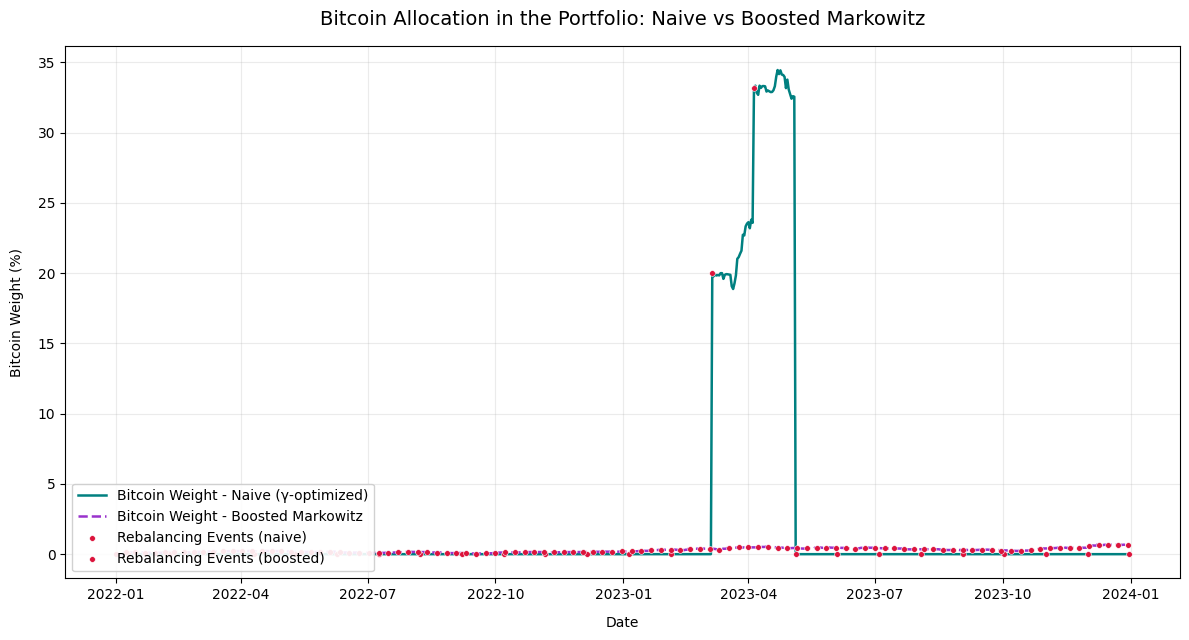

In [15]:
# === 0) Extraction des poids Bitcoin ===
btc_weights_boosted = np.array([w[0] for w in result_boosted["weights_record"]], dtype=float)  # Boosted Markowitz
btc_weights_naive = np.array(weights_hist[:, 0], dtype=float)                                  # Naive (γ-optimized)

# === 1) Index et dates ===
dates_boosted = pd.to_datetime(result_boosted["dates"])
dates_naive = returns.index[window + 1 : len(returns)]

# Alignement (au cas où les longueurs diffèrent)
min_len_naive = min(len(dates_naive), len(btc_weights_naive))
dates_naive = dates_naive[:min_len_naive]
btc_weights_naive = btc_weights_naive[:min_len_naive]

min_len_boosted = min(len(dates_boosted), len(btc_weights_boosted))
dates_boosted = dates_boosted[:min_len_boosted]
btc_weights_boosted = btc_weights_boosted[:min_len_boosted]

# === 2) Rebalancing indices et dates ===
rebalance_indices_naive = [i for i in range(len(btc_weights_naive)) if i % rebalance_freq == 0]
rebalance_dates_naive = [dates_naive[i] for i in rebalance_indices_naive]
rebalance_values_naive = [btc_weights_naive[i] for i in rebalance_indices_naive]

rebalance_idx_boosted = [
    i for i, d in enumerate(dates_boosted) if d in result_boosted["rebalance_dates"]
]
rebalance_dates_boosted = [dates_boosted[i] for i in rebalance_idx_boosted]
rebalance_values_boosted = [btc_weights_boosted[i] for i in rebalance_idx_boosted]

# === 3) Tracé du poids du Bitcoin ===
plt.figure(figsize=(12, 6.5))

# Courbe Naive
plt.plot(
    dates_naive,
    btc_weights_naive * 100,
    label="Bitcoin Weight - Naive (γ-optimized)",
    color="teal",
    linestyle="-",
    linewidth=1.8
)

# Courbe Boosted
plt.plot(
    dates_boosted,
    btc_weights_boosted * 100,
    label="Bitcoin Weight - Boosted Markowitz",
    color="darkorchid",
    linestyle="--",
    linewidth=1.8
)

# Points de rebalancement
plt.scatter(
    rebalance_dates_naive,
    np.array(rebalance_values_naive) * 100,
    color="crimson",
    label="Rebalancing Events (naive)",
    s=17, zorder=5, edgecolor="white", linewidth=0.4
)
plt.scatter(
    rebalance_dates_boosted,
    np.array(rebalance_values_boosted) * 100,
    color="crimson",
    label="Rebalancing Events (boosted)",
    s=17, zorder=5, edgecolor="white", linewidth=0.4
)

# === 4) Mise en forme du graphique ===
plt.title("Bitcoin Allocation in the Portfolio: Naive vs Boosted Markowitz", pad=15, fontsize=14)
plt.xlabel("Date", labelpad=10)
plt.ylabel("Bitcoin Weight (%)", labelpad=10)
plt.grid(True, alpha=0.25)
plt.legend(framealpha=0.9, loc="lower left")  # 👈 légende en bas à gauche
plt.tight_layout()
plt.show()
